In [1]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam

from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt
from IPython.display import Image, display
from keras.layers import Activation, Dense, RepeatVector, Embedding, LSTM, TimeDistributed, Concatenate
from imp import reload
from keras.layers import Concatenate


In [2]:
# Load data
images_path = '../input/caption-images/Flickr8K/Flicker8k_Images/' 
captions = open('../input/caption-images/Flickr8K/Flickr8k_text/Flickr8k.token.txt', 'r').read().split("\n")
x_train = open('../input/caption-images/Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt', 'r').read().split("\n")
x_val = open('../input/caption-images/Flickr8K/Flickr8k_text/Flickr_8k.valImages.txt', 'r').read().split("\n")
x_test = open('../input/caption-images/Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt', 'r').read().split("\n")

In [3]:
print("hi")

hi


In [4]:
# Loading captions as values and images as key in dictionary
img_caption = {}

for i in range(len(captions)-1):
    l = captions[i].split('#')
    caption_text = l[1].split('\t')[1]
#     print(l[0])
#     print(x_train)
    if l[0] in x_train:
        if l[0] in img_caption:
            img_caption[l[0]].append(caption_text)
        else:
            img_caption[l[0]] = [caption_text] 

# for ix in range(len(captions)-1):
#     temp = captions[ix].split("#")
#     if temp[0] in img_caption:
#         img_caption[temp[0]].append(temp[1][2:])
#     else:
#         img_caption[temp[0]] = [temp[1][2:]]

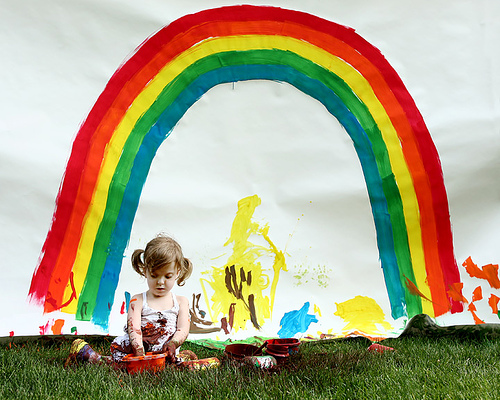

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [5]:
# displaying an image and captions given to it
temp = captions[10].split("#")
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(img_caption[temp[0]])):
    print(img_caption[temp[0]][ix])

In [6]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [7]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
def write_caption(x_data, dataset):
    for img in x_data:
        if img == '':
            continue
        if img in img_caption:
            for capt in img_caption[img]:
                caption = "<start> "+ capt + " <end>"
                dataset.write((img+"\t"+caption+"\n").encode())
                dataset.flush()
    dataset.close()

write_caption(x_train, train_dataset)
write_caption(x_test, test_dataset)
write_caption(x_val, val_dataset)

In [8]:

model = tf.keras.applications.ResNet50(  include_top=False, weights='imagenet',input_shape=(224,224,3), pooling='avg')
model.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [9]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [10]:
train_data = {}
ctr=0
print(len(x_train))
for ix in x_train:
    if ix == "":
        print("YESS")
        continue
    if ctr >= 3000:
        break
    ctr+=1
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

6001


In [11]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )  

In [12]:
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [13]:
pd_dataset.head()

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [14]:
sentences = []
print(ds)
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

[['2513260012_03d33305cf.jpg'
  '<start> A black dog is running after a white dog in the snow . <end>']
 ['2513260012_03d33305cf.jpg'
  '<start> Black dog chasing brown dog through snow <end>']
 ['2513260012_03d33305cf.jpg'
  '<start> Two dogs chase each other across the snowy ground . <end>']
 ...
 ['2671602981_4edde92658.jpg'
  '<start> A young girl in a swimming suit jumps into a body of water . <end>']
 ['2671602981_4edde92658.jpg'
  '<start> A young girl jumping out of the water <end>']
 ['2671602981_4edde92658.jpg'
  '<start> The girl in the bathing suit is poised in midair next to the blue water . <end>']]
30000


In [15]:
sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [16]:
words1 = [i.split() for i in sentences]

# Creating a list of all unique words
words = []
for i in words1:
    words.extend(i)
words = list(set(words))

print(len(words))

vocab_size = len(words)

8253


In [17]:
# Vectorization
word_2_indices = {val:index for index, val in enumerate(words)}
indices_2_word = {index:val for index, val in enumerate(words)}

In [18]:
print(indices_2_word)

{0: 'roping', 1: 'DU', 2: 'acroos', 3: 'pristine', 4: 'devil', 5: 'shoe', 6: 'along', 7: 'chasing', 8: 'landform', 9: 'escorted', 10: 'Winnie', 11: 'jacked', 12: 'cue', 13: 'Dalmatians', 14: 'paint', 15: 'hanging', 16: 'tones', 17: 'piercing', 18: 'games', 19: 'hovering', 20: 'facing', 21: 'filmed', 22: 'hauling', 23: 'mold', 24: 'suntanning', 25: 'classic', 26: 'laborador', 27: 'Hindu', 28: 'bills', 29: 'shore', 30: 'frilly', 31: 'reaching', 32: 'dodges', 33: 'crouching', 34: 'castles', 35: 'crampons', 36: 'picure', 37: 'cheer', 38: 'bulls', 39: 'dachshund', 40: 'taught', 41: 'orange-hooded', 42: 'sweatshir', 43: 'cathcer', 44: 'sprints', 45: 'sleep', 46: 'bicyler', 47: 'global', 48: 'mom', 49: 'Photographer', 50: 'spool', 51: 'spin-art', 52: 'phones', 53: 'hung', 54: 'unknown', 55: 'goal', 56: 'play', 57: 'sunsets', 58: 'collects', 59: 'Both', 60: 'obese', 61: 'cleaned', 62: 'use', 63: 'love', 64: 'periods', 65: 'Ranger', 66: 'emphatically', 67: 'beads', 68: 'dolphin', 69: 'laden', 7

In [19]:
word_2_indices['UNK'] = 0
indices_2_word[0] = 'UNK'

In [20]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

8254


In [21]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [22]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

(30000,)
(30000,)


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [23]:
print(padded_sequences[0])

[[3000    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [3000 5637    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [3000 5637 3116    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [3000 5637 3116 5675    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [3000 5637 3116 5675 2751    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [24]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[0][ix][iy]],)
    print("\n")


<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
running
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<sta

In [25]:
num_of_images = 2000

In [26]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [27]:
for ix in range(num_of_images):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)


In [28]:
print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [29]:
print("running")

running


In [30]:
with open('../input/caption-images/Flickr8K/train_encoded_images.p/train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

In [31]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0].encode() in encoded_images.keys():
        imgs.append(list(encoded_images[ds[ix, 0].encode()]))

imgs = np.asarray(imgs)
print(imgs.shape)

(15000, 2048)


In [32]:
images = []
# print(len(padded_sequences))
# print(len(imgs))
for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(25493, 2048)


In [33]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

25493


###  **Model**

In [34]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [35]:
images = np.load("images.npy")

print(images.shape)

(25493, 2048)


In [36]:
imag = np.load("image_names.npy")
        
print(imag.shape)

(25493,)


In [37]:
embedding_size = 128
max_len = 40

In [38]:
image_model = Sequential()
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))
image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [39]:
language_model = Sequential()
language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))
language_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           1056512   
_________________________________________________________________
lstm (LSTM)                  (None, 40, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [40]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1056512     embedding_input[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
______________________________________________________________________________________________

In [41]:
# images = np.reshape(images, (images.shape[0], 1, images.shape[1]))
# captions = np.reshape(captions, (captions.shape[0], 1, captions.shape[1]))
# hist = model.fit([images[:94], captions[:94]], next_words, batch_size=512, epochs=200)
hist = model.fit([images, captions], next_words, batch_size=512, epochs=200)


Epoch 1/200
50/50 [==============================] - 135s 3s/step - loss: 6.2237 - accuracy: 0.0679
Epoch 2/200
50/50 [==============================] - 133s 3s/step - loss: 5.3339 - accuracy: 0.0754
Epoch 3/200
50/50 [==============================] - 131s 3s/step - loss: 5.2166 - accuracy: 0.0780
Epoch 4/200
50/50 [==============================] - 130s 3s/step - loss: 5.1585 - accuracy: 0.0759
Epoch 5/200
50/50 [==============================] - 131s 3s/step - loss: 5.0978 - accuracy: 0.0822
Epoch 6/200
50/50 [==============================] - 131s 3s/step - loss: 4.8409 - accuracy: 0.1382
Epoch 7/200
50/50 [==============================] - 135s 3s/step - loss: 4.6076 - accuracy: 0.1780
Epoch 8/200
50/50 [==============================] - 131s 3s/step - loss: 4.4014 - accuracy: 0.2034
Epoch 9/200
50/50 [==============================] - 130s 3s/step - loss: 4.2013 - accuracy: 0.2315
Epoch 10/200
50/50 [==============================] - 130s 3s/step - loss: 4.0762 - accuracy: 0.2448

In [42]:
model.save_weights("model_weights.h5")

### Predictions

In [43]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [44]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    print(pred)
    return pred

In [45]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [46]:
img = "../input/caption-images/Flickr8K/Flicker8k_Images/1007129816_e794419615.jpg"

test_img = get_encoding(resnet, img)

[0.41433612 2.69202    0.         ... 0.11422747 0.         0.17733644]


In [47]:
img1 = "../input/caption-images/Flickr8K/subjective_img/sample1.jpg"
img2="../input/caption-images/Flickr8K/subjective_img/sample2.jpg"
img3="../input/caption-images/Flickr8K/subjective_img/sample3.jpg"
img4="../input/caption-images/Flickr8K/subjective_img/sample4.jpg"
img5="../input/caption-images/Flickr8K/subjective_img/sample5.jpg"
img6="../input/caption-images/Flickr8K/subjective_img/sample6.jpeg"
img7="../input/caption-images/Flickr8K/subjective_img/sample7.jpeg"
img8="../input/caption-images/Flickr8K/subjective_img/sample8.jpeg"
img9="../input/caption-images/Flickr8K/subjective_img/sample9.jpeg"
test_img1 = get_encoding(resnet, img1)
test_img2 = get_encoding(resnet, img2)
test_img3 = get_encoding(resnet, img3)
test_img4 = get_encoding(resnet, img4)
test_img5 = get_encoding(resnet, img5)
test_img6 = get_encoding(resnet, img6)
test_img7 = get_encoding(resnet, img7)
test_img8 = get_encoding(resnet, img8)
test_img9 = get_encoding(resnet, img9)

[0.30376044 0.7650835  0.10864504 ... 0.49562928 0.06895167 2.8469052 ]
[0.11765072 2.939443   0.3794547  ... 2.255524   0.19093381 1.4393094 ]
[0.25389937 1.7285948  0.29665008 ... 0.46473718 0.00422226 0.25932634]
[0.8812093  0.85467476 0.39315423 ... 0.11798257 0.22685894 1.3343389 ]
[1.9379803  1.2192597  0.6563993  ... 0.02901566 0.         0.        ]
[1.4971735  0.08641127 0.         ... 1.0216889  0.75515693 0.08416817]
[0.5103226  4.497488   0.         ... 0.27355883 0.61019796 0.03256867]
[0.37076235 0.04919424 0.01228885 ... 0.03441623 0.33915803 0.        ]
[0.33796027 2.1468503  0.         ... 1.5904444  0.46995342 0.23371638]


In [48]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

In [49]:
Argmax_Search1 = predict_captions(test_img1)
Argmax_Search2 = predict_captions(test_img2)
Argmax_Search3 = predict_captions(test_img3)
Argmax_Search4 = predict_captions(test_img4)
Argmax_Search5 = predict_captions(test_img5)
Argmax_Search6 = predict_captions(test_img6)
Argmax_Search7 = predict_captions(test_img7)
Argmax_Search8 = predict_captions(test_img8)
Argmax_Search9 = predict_captions(test_img9)

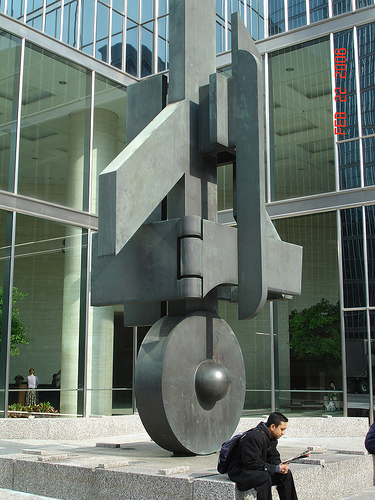

A newly taking this to to pink shirt is chases a picture above a beach .


In [50]:
z1 = Image(filename=img1)
display(z1)
print(Argmax_Search1)
from nltk.translate.bleu_score import corpus_bleu
reference ="A man sitting"
comp1=reference.split()
comp2=Argmax_Search1.split()
# score1 = corpus_bleu(comp1,comp2)
# print(score1)

In [51]:
blue_score=0.03

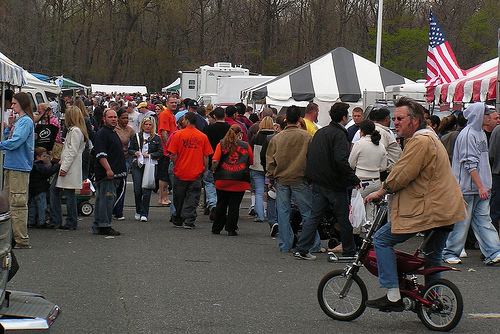

A group of men sit in rocks pigeons .


In [52]:
z2 = Image(filename=img2)
display(z2)
print(Argmax_Search2)
from nltk.translate.bleu_score import corpus_bleu
reference ="Many people at a fare"
comp1=reference.split()
comp2=Argmax_Search2.split()
# score2 = corpus_bleu(comp1,comp2)
# print(score2)

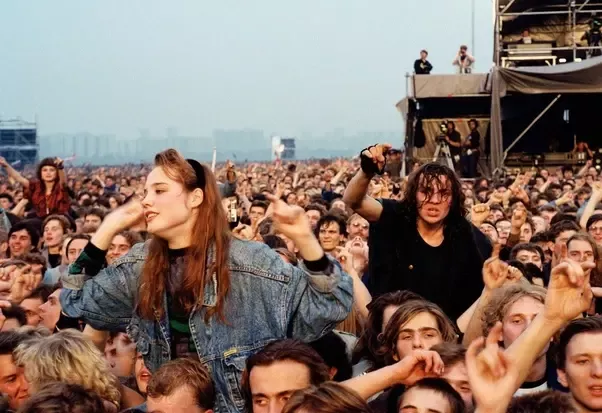

A bunch of people look , at indoor stool .


In [53]:
z3 = Image(filename=img3)
display(z3)
print(Argmax_Search3)
from nltk.translate.bleu_score import corpus_bleu
reference ="Crowd Gathering"
comp1=reference.split()
comp2=Argmax_Search3.split()
# score3 = corpus_bleu(comp1,comp2)
# print(score3)

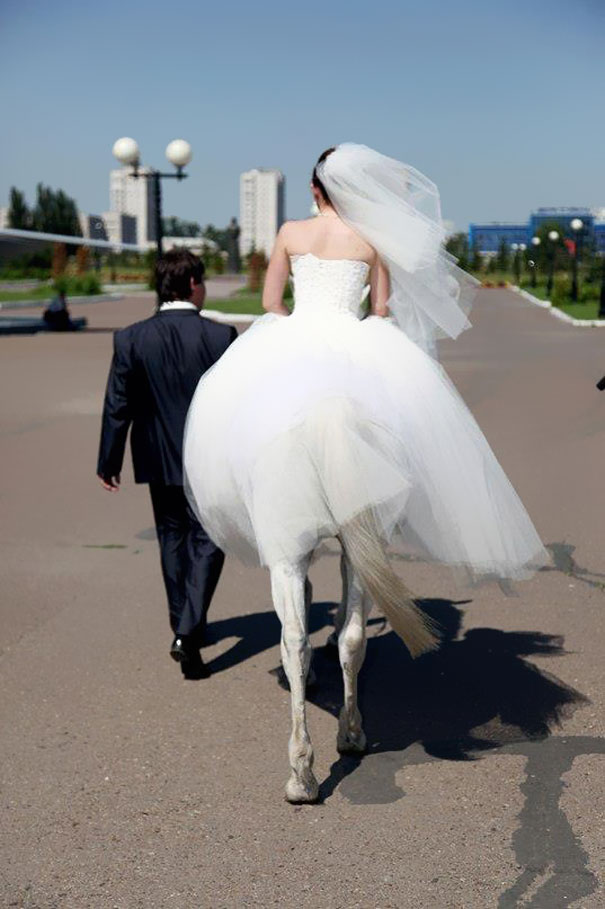

A man is wearing an 3 jacket riding three bike down his white white white chair down three group .


In [54]:
z4 = Image(filename=img4)
display(z4)
print(Argmax_Search4)
from nltk.translate.bleu_score import corpus_bleu
reference ="A man with a tall girl"
comp1=reference.split()
comp2=Argmax_Search4.split()
# score4 = corpus_bleu(comp1,comp2)
# print(score4)

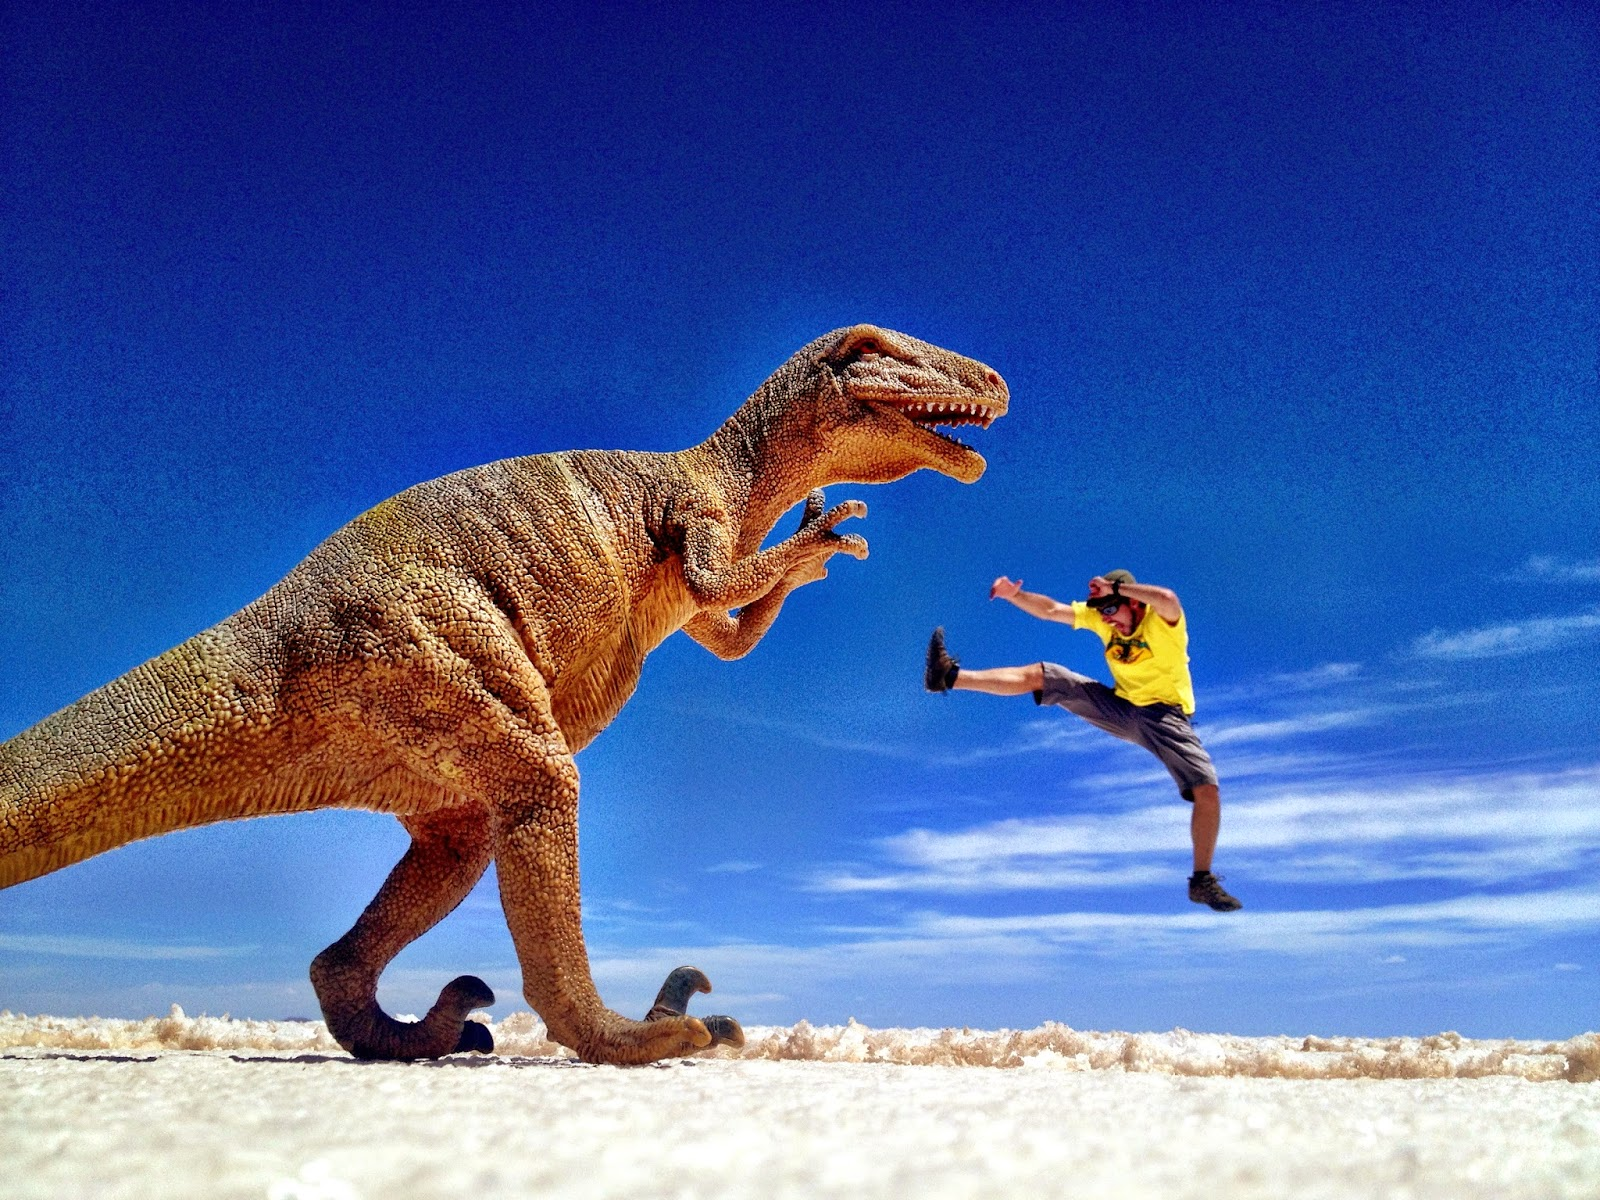

A man is is sitting on a snowy mountains .


In [55]:
z5 = Image(filename=img5)
display(z5)
print(Argmax_Search5)
from nltk.translate.bleu_score import corpus_bleu
reference ="A man fighting with dinosaur"
comp1=reference.split()
comp2=Argmax_Search5.split()
# score5 = corpus_bleu(comp1,comp2)
# print(score5)

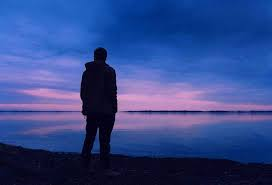

A group of people are and are set at in a , small wave on a ocean .


In [56]:
z6 = Image(filename=img6)
display(z6)
print(Argmax_Search6)
from nltk.translate.bleu_score import corpus_bleu
reference ="A man standingr"
comp1=reference.split()
comp2=Argmax_Search6.split()
# score6 = corpus_bleu(comp1,comp2)
# print(score6)

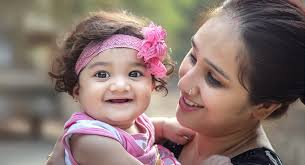

A child are in a face paint in a white white brown brown blowup


In [57]:
z7 = Image(filename=img7)
display(z7)
print(Argmax_Search7)
from nltk.translate.bleu_score import corpus_bleu
reference ="A woman with a child"
comp1=reference.split()
comp2=Argmax_Search7.split()
# score7 = corpus_bleu(comp1,comp2)
# print(score7)

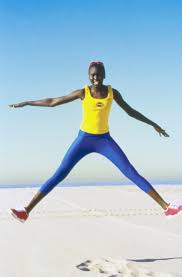

A young girl wearing a pink tank shirt jumping on a slide .


In [58]:
z8 = Image(filename=img8)
display(z8)
print(Argmax_Search8)
from nltk.translate.bleu_score import corpus_bleu
reference ="A woman on ice"
comp1=reference.split()
comp2=Argmax_Search8.split()
# score8 = corpus_bleu(comp1,comp2)
# print(score8)

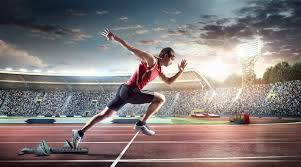

A little boy is swinging on a pole at the background .


In [59]:
z9 = Image(filename=img9)
display(z9)
print(Argmax_Search9)
from nltk.translate.bleu_score import corpus_bleu
reference ="A man running"
comp1=reference.split()
comp2=Argmax_Search9.split()
# score9 = corpus_bleu(comp1,comp2)
# print(score9)

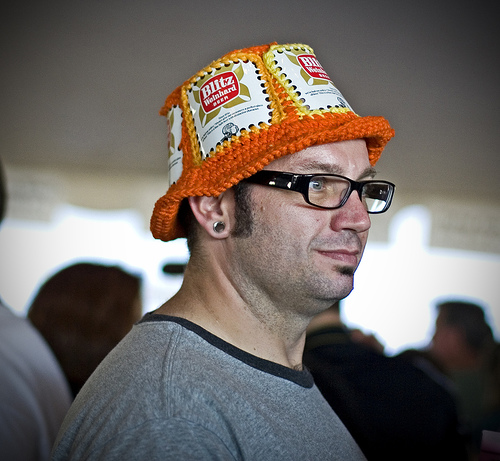

A man wearing a red and reading a woolen .


In [60]:
z = Image(filename=img)
display(z)
print(Argmax_Search)
from nltk.translate.bleu_score import corpus_bleu
reference ="two children slept on bed upside down"
comp1=reference.split()
comp2=Argmax_Search.split()
# score = corpus_bleu(comp1,comp2)
# print(score)

argmax_search gives me the string;now given .jpg file I have to find the captions possible 

In [61]:
# Totalscore=(score1+score2+score3+score4+score5+score6+score7+score8+score9)/9
# print(Totalscore)
print(blue_score)

0.03


In [62]:
print("done!")

done!
